In [43]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import st_remux as st

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical



%matplotlib inline

In [44]:
# Config
# highpath = 'datasets/high.csv'
# lowpath = 'datasets/none.csv'
# hi = st.raw_to_arr(high, fs, win_len, 0)
# lo = st.raw_to_arr(low, fs, win_len, 0)
highdir = 'data_for/high'
meddir = 'datasets/med'
lowdir = 'datasets/low'
nonedir = 'datasets/none'



fs = 4000
win_len = 40

use_filter = 0   # weird results if we use python filtering

use_matlab_backend = 0

In [45]:
# high = np.genfromtxt(highpath, delimiter=',')
# low = np.genfromtxt(lowpath, delimiter=',')

In [46]:
if use_matlab_backend:
    print('Using MATLAB signal processing backend')
    # high_dir = 'datasets/high/'
    # low_dir = 'datasets/low/'

    high_dir = 'C:/Users/Geoffrey/Documents/MATLAB/S transform time frequency/high/'
    low_dir = 'C:/Users/Geoffrey/Documents/MATLAB/S transform time frequency/low/'

    def generate_3darray(directory):
        files = os.listdir(directory)
        dims = np.genfromtxt(directory + files[0], delimiter=',').shape
        length = len(files)
        arr = np.zeros((length, dims[0], dims[1]))

        for idx, val in enumerate(files):
            arr[idx] = np.genfromtxt(directory + val, delimiter=',')

        return arr

    hi = generate_3darray(high_dir)
    lo = generate_3darray(low_dir)
    
else: 
    print('Using native backend')
    hi = st.raw_to_arr(highdir, fs, win_len, 0)
    med = st.raw_to_arr(meddir, fs, win_len, 0)
    lo = st.raw_to_arr(lowdir, fs, win_len, 0)
    none = st.raw_to_arr(nonedir, fs, win_len, 0)



Using native backend


In [48]:
X = np.concatenate((hi, med, lo, none))
d= X.shape
print(d)

hi_Y = np.ones(len(hi), dtype=int) * 3
med_Y = np.ones(len(med), dtype=int) * 2
lo_Y = np.ones(len(lo), dtype=int) * 1
none_Y = np.zeros(len(none), dtype=int)

Y = np.concatenate((hi_Y, med_Y, lo_Y, none_Y))

(23470, 16, 40)


In [6]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.1)

In [7]:
print('Training data shape: ', train_X.shape, train_Y.shape)
print('Testing data shape: ', test_X.shape, test_Y.shape)

Training data shape:  (21123, 16, 40) (21123,)
Testing data shape:  (2347, 16, 40) (2347,)


In [8]:
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs: ', nClasses)
print('Output classes: ', classes)

Total number of outputs:  4
Output classes:  [0 1 2 3]


Text(0.5,1,'Ground Truth: 2')

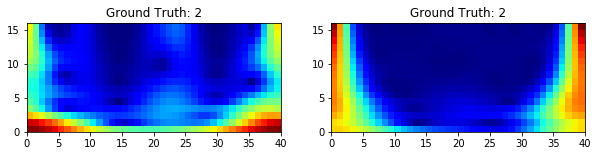

In [9]:
plt.figure(figsize=[10,2])

# Display first image in training set
plt.subplot(121)
plt.pcolormesh(train_X[0,:,:], cmap='jet')
plt.title("Ground Truth: {}".format(train_Y[0]))

# Display second image in testing set
plt.subplot(122)
plt.pcolormesh(test_X[1], cmap='jet')
plt.title("Ground Truth: {}".format(test_Y[1]))

In [10]:
ydim = train_X[0].shape[0]
xdim = train_X[0].shape[1]
train_X = train_X.reshape(-1, ydim, xdim, 1)
test_X = test_X.reshape(-1, ydim, xdim, 1)
train_X.shape, test_X.shape

((21123, 16, 40, 1), (2347, 16, 40, 1))

In [11]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [12]:
# Change labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# See the difference?
print('Original label: ', train_Y[0])
print('After conversion to one-hot: ', train_Y_one_hot[0])

Original label:  2
After conversion to one-hot:  [0. 0. 1. 0.]


In [13]:
train_Y_one_hot.shape

(21123, 4)

In [14]:
# Partition data for 80% training and 20% validation
# should reduce overfitting and boost test performance

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2)

train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((16898, 16, 40, 1), (4225, 16, 40, 1), (16898, 4), (4225, 4))

In [15]:
# let's get down to business
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [16]:
# Parameters
batch_size = 64
epochs = 50
num_classes = nClasses

In [17]:
emg_model = Sequential()
emg_model.add(
    Conv2D(
        32, 
        kernel_size=(3, 3), 
        activation='linear', 
        input_shape=(ydim, xdim, 1), 
        padding='same'))
emg_model.add(LeakyReLU(alpha=0.1))
emg_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
emg_model.add(Dropout(0.25))
emg_model.add(
    Conv2D(
        64,
        (3, 3),
        activation='linear',
        padding='same'))
emg_model.add(LeakyReLU(alpha=0.1))
emg_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
emg_model.add(Dropout(0.25))
emg_model.add(
    Conv2D(
        128,
        (3, 3),
        activation='linear',
        padding='same'))
emg_model.add(LeakyReLU(alpha=0.1))
emg_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
emg_model.add(Dropout(0.4))
emg_model.add(Flatten())
emg_model.add(Dense(128, activation='linear'))
emg_model.add(LeakyReLU(alpha=0.1))
emg_model.add(Dropout(0.3))
emg_model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
emg_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])

In [19]:
emg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 40, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 40, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 20, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 20, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 20, 64)         18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 20, 64)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 10, 64)        

In [20]:
emg_train = emg_model.fit(
    train_X,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label))

Instructions for updating:
Use tf.cast instead.
Train on 16898 samples, validate on 4225 samples
Epoch 1/50
16898/16898 [==============================] - 22s 1ms/step - loss: 1.2456 - accuracy: 0.4240 - val_loss: 1.3007 - val_accuracy: 0.4353
Epoch 2/50
16898/16898 [==============================] - 21s 1ms/step - loss: 1.0663 - accuracy: 0.5207 - val_loss: 0.9443 - val_accuracy: 0.6170
Epoch 3/50
16898/16898 [==============================] - 21s 1ms/step - loss: 0.9666 - accuracy: 0.5800 - val_loss: 0.8862 - val_accuracy: 0.6289
Epoch 4/50
16898/16898 [==============================] - 20s 1ms/step - loss: 0.9103 - accuracy: 0.6144 - val_loss: 0.8919 - val_accuracy: 0.6267
Epoch 5/50
16898/16898 [==============================] - 21s 1ms/step - loss: 0.8917 - accuracy: 0.6219 - val_loss: 0.8233 - val_accuracy: 0.6734
Epoch 6/50
16898/16898 [==============================] - 21s 1ms/step - loss: 0.8441 - accuracy: 0.6474 - val_loss: 0.7669 - val_accuracy: 0.6933
Epoch 7/50
16898/1689

In [21]:
test_eval = emg_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [22]:
print('Test loss: ', test_eval[0])
print('Test accuracy: ', test_eval[1])

Test loss:  0.5678808849874739
Test accuracy:  0.7856838703155518


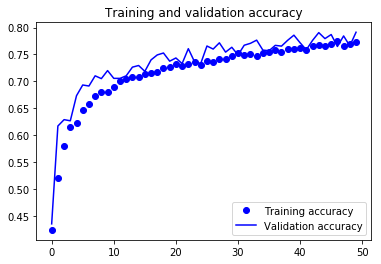

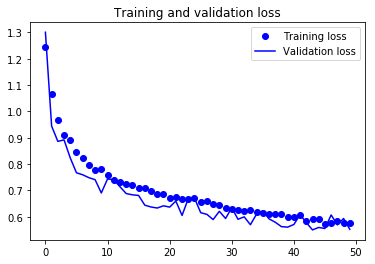

In [23]:
# Visualization
accuracy = emg_train.history['accuracy']
val_accuracy = emg_train.history['val_accuracy']
loss = emg_train.history['loss']
val_loss = emg_train.history['val_loss']
epoch = range(len(accuracy))
plt.plot(epoch, accuracy, 'bo', label='Training accuracy')
plt.plot(epoch, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
emg_train_dropout = emg_model.fit(
    train_X,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label))

Train on 16898 samples, validate on 4225 samples
Epoch 1/50
16898/16898 [==============================] - 22s 1ms/step - loss: 0.5707 - accuracy: 0.7699 - val_loss: 0.5686 - val_accuracy: 0.7818
Epoch 2/50
16898/16898 [==============================] - 46s 3ms/step - loss: 0.5725 - accuracy: 0.7723 - val_loss: 0.5489 - val_accuracy: 0.7908
Epoch 3/50
16898/16898 [==============================] - 28s 2ms/step - loss: 0.5704 - accuracy: 0.7698 - val_loss: 0.5663 - val_accuracy: 0.7808
Epoch 4/50
16898/16898 [==============================] - 20s 1ms/step - loss: 0.5719 - accuracy: 0.7703 - val_loss: 0.5535 - val_accuracy: 0.7856
Epoch 5/50
16898/16898 [==============================] - 2119s 125ms/step - loss: 0.5643 - accuracy: 0.7726 - val_loss: 0.5863 - val_accuracy: 0.7688
Epoch 6/50
16898/16898 [==============================] - 561s 33ms/step - loss: 0.5644 - accuracy: 0.7731 - val_loss: 0.5365 - val_accuracy: 0.7934
Epoch 7/50
16898/16898 [==============================] - 21s 1

In [25]:
# emg_model.save("emg_model_dropout_new.h5py")

In [26]:
test_eval= emg_model.evaluate(test_X, test_Y_one_hot, verbose=1)

2347/2347 [==============================] - 1s 345us/step


In [27]:
print('Test loss: ', test_eval[0])
print('Test accuracy: ', test_eval[1])

Test loss:  0.5535070183026216
Test accuracy:  0.7933531999588013


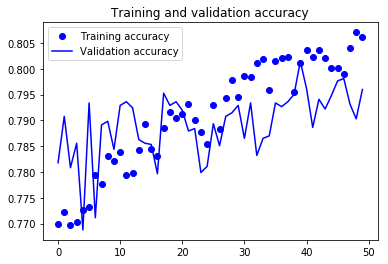

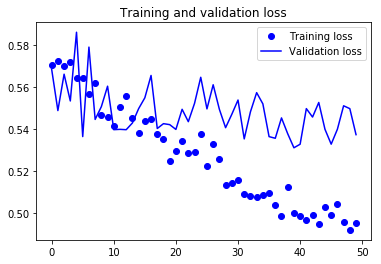

In [28]:
# Visualization
accuracy = emg_train_dropout.history['accuracy']
val_accuracy = emg_train_dropout.history['val_accuracy']
loss = emg_train_dropout.history['loss']
val_loss = emg_train_dropout.history['val_loss']
epoch = range(len(accuracy))
plt.plot(epoch, accuracy, 'bo', label='Training accuracy')
plt.plot(epoch, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [29]:
predicted_classes = emg_model.predict(test_X)

In [30]:
predicted_classes = np.argmax(np.round(predicted_classes), axis=1)

In [31]:
predicted_classes.shape, test_Y.shape

((2347,), (2347,))

Found 1808 correct labels


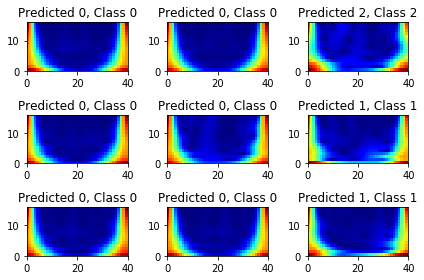

In [32]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct, in enumerate(correct[:9]):
    plt.subplot(3, 3, i+1)
    plt.pcolormesh(test_X[correct].reshape(ydim, xdim), cmap='jet')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Found 539 incorrect labels


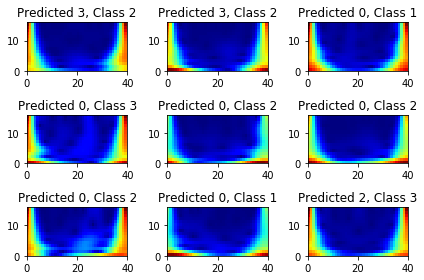

In [33]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect, in enumerate(incorrect[:9]):
    plt.subplot(3, 3, i+1)
    plt.pcolormesh(test_X[incorrect].reshape(ydim, xdim), cmap='jet')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

In [34]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.71      0.97      0.82       637
    Class 1       0.82      0.82      0.82       760
    Class 2       0.81      0.62      0.70       537
    Class 3       0.77      0.56      0.65       413

avg / total       0.78      0.77      0.76      2347

